# Import binary data - Taken from binarized dataset


In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

C:\Users\thuli\AppData\Roaming\Python\Python39\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Load the dataset from csv files
full_dataset = pd.read_csv("../../output_full_web_or_not.csv", header=0, usecols=[*range(1,23)], sep=";") 
full_dataset.dropna(axis = 0, inplace = True)
print("The shape of the full dataset: " + str(full_dataset.shape))

full_dataset.head()

# Set of features in the dataset
features = list(full_dataset.columns)
print("Features: " + str(features[:-1]))

activity_df = full_dataset

The shape of the full dataset: (382, 22)
Features: ['session_time', '%tcp_protocol', '%udp_protocol', 'ul_data_volume', 'max_ul_volume', 'min_ul_volume', 'avg_ul_volume', 'std_ul_volume', '%ul_volume', 'dl_data_volume', 'max_dl_volume', 'min_dl_volume', 'avg_dl_volume', 'std_dl_volume', '%dl_volume', 'nb_uplink_packet', 'nb_downlink_packet', 'ul_packet', 'dl_packet', 'kB/s', 'nb_packet/s']


In [3]:
y_df = activity_df['output'].to_frame()
X_df = activity_df[activity_df.columns.difference(['output'])]

X_train, X_test, y_train_orig, y_test_orig = train_test_split(X_df, y_df, stratify=y_df, train_size=0.7, random_state=9)

print("Shape of the training dataset: " + str(X_train.shape) + ", " + str(y_train_orig.shape))
print("Shape of the testing dataset: " + str(X_test.shape) + ", " + str(y_test_orig.shape))

# print(X_train.index.tolist())

Shape of the training dataset: (267, 21), (267, 1)
Shape of the testing dataset: (115, 21), (115, 1)


In [4]:
y_train_orig.value_counts()

output
1         212
2          55
dtype: int64

# Create model

In [5]:
import lightgbm as ltb
clf = ltb.LGBMClassifier()
# Using Y_train here got an error of shape
clf.fit(X_train, y_train_orig)

c:\Users\thuli\anaconda3\envs\mi_xai\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\thuli\anaconda3\envs\mi_xai\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier()

# Shapash

In [6]:
from shapash import SmartExplainer
# features = list(features)
features_dict = dict(zip(features, features))
xpl = SmartExplainer(
    model=clf,
    #preprocessing=encoder,   # Optional: compile step can use inverse_transform method
    features_dict=features_dict # optional parameter, specifies label for features name 
)
xpl.compile(x=X_test,
            # y_target=y_test_orig # Optional: allows to display True Values vs Predicted Values
           )

In [7]:
xpl.plot.features_importance()

In [8]:
xpl.plot.contribution_plot("%tcp_protocol")

In [9]:
xpl.plot.local_plot(index=10)

In [10]:
from shapash.explainer.consistency import Consistency
cns = Consistency()

cns.compile(x=X_train, # Dataset for which we need explanations
            model=clf, # Model to explain
            #preprocessing=encoder, # Optional
            )

 30%|███       | 3/10 [03:03<07:08, 61.22s/it]


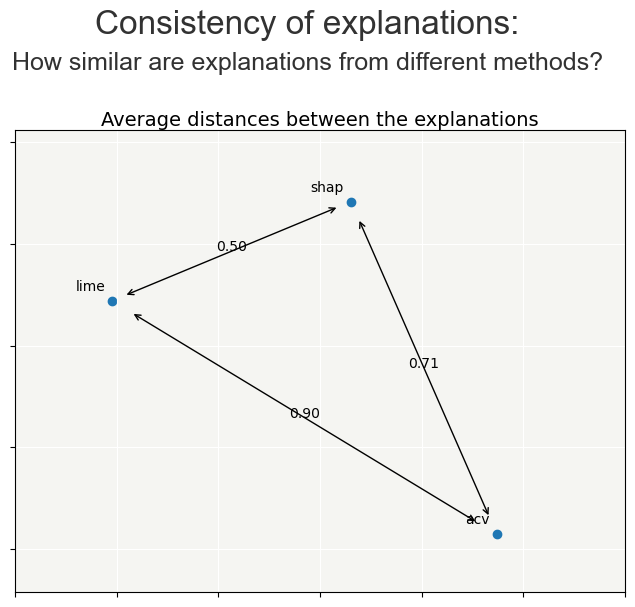

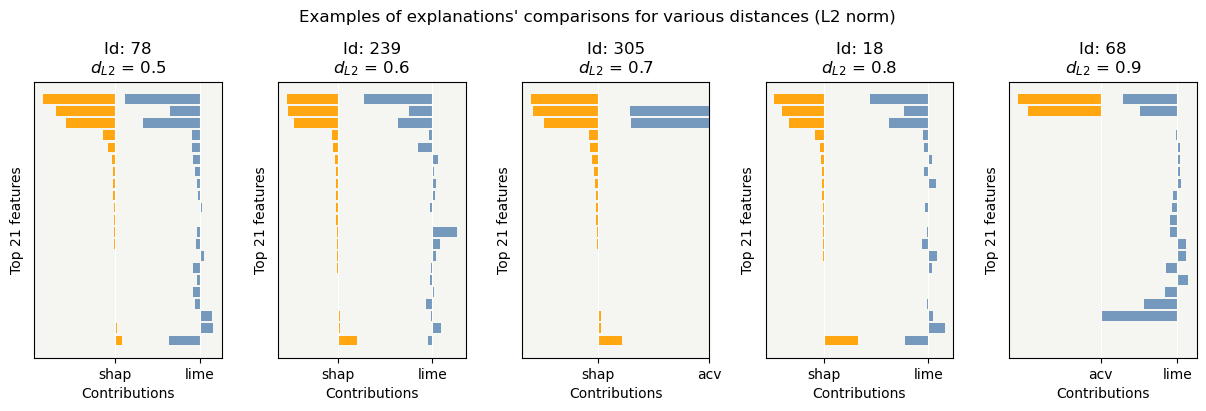

In [11]:
cns.consistency_plot(max_features=21)

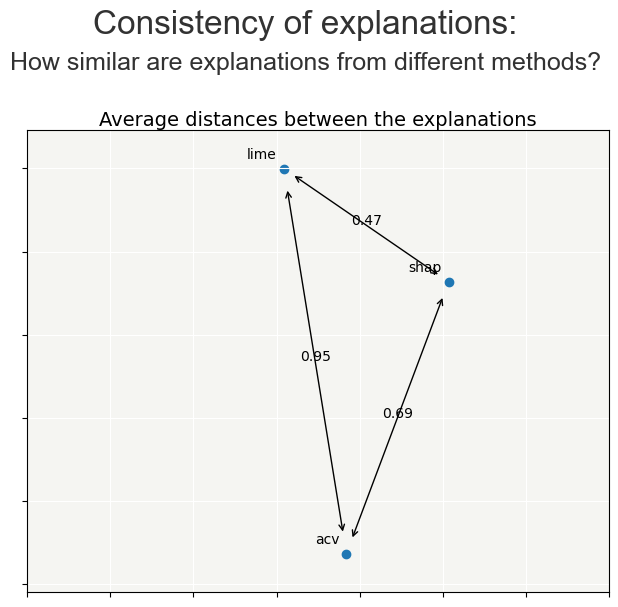

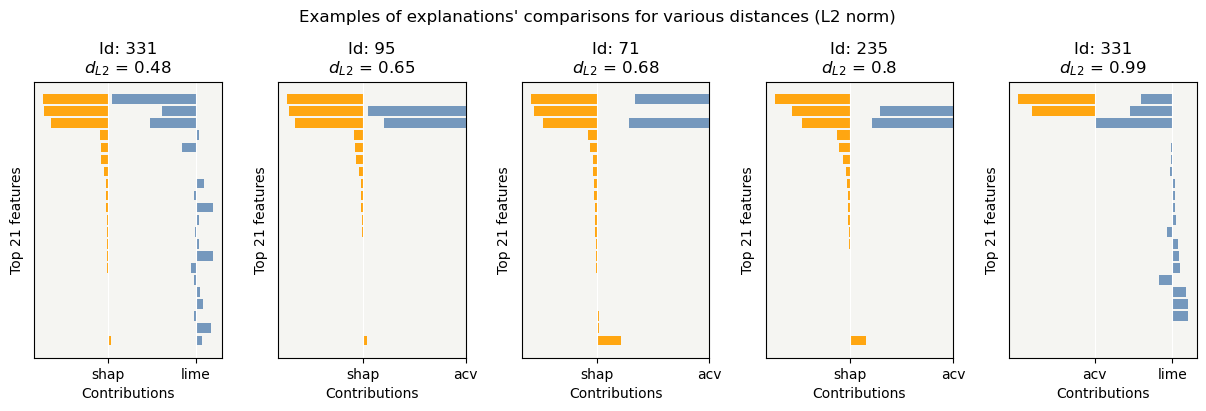

In [12]:
index = [1, 2, 3, 4, 5]
cns.consistency_plot(selection=index, max_features=21)

In [13]:
# xpl.plot.compacity_plot(selection=index, approx=.85, nb_features=3)
xpl.plot.compacity_plot()

In [14]:
xpl.plot.stability_plot()

In [25]:
xpl.plot.stability_plot(selection=[1,24], max_features=5, distribution="boxplot")

In [ ]:
xpl.plot.local_neighbors_plot(index=5)

In [ ]:
# import shap

# treeSHAP = shap.TreeExplainer(clf).shap_values(X_train, check_additivity=False)[1]
# samplingSHAP = shap.SamplingExplainer(clf.predict_proba, shap.kmeans(X_train, 200)).shap_values(X_train, check_additivity=False)[1]
# kernelSHAP = shap.KernelExplainer(clf.predict_proba, shap.kmeans(X_train, 200)).shap_values(X_train, check_additivity=False)[1]

# treeSHAP = pd.DataFrame(treeSHAP, columns=X_train.columns)
# samplingSHAP = pd.DataFrame(samplingSHAP, columns=X_train.columns)
# kernelSHAP = pd.DataFrame(kernelSHAP, columns=X_train.columns)

In [ ]:
xpl.generate_report(
    output_file='report.html',
    project_info_file='shapash_project_info.yml',
    x_train=X_train,
    y_train=y_train_orig,
    y_test=y_test_orig,
    title_story="User Network Activities Classification",
    title_description="This document is a data science report of the user network activities classification.",
    metrics=[
        {
            'path': 'sklearn.metrics.mean_squared_error',
            'name': 'Mean squared error',  # Optional : name that will be displayed next to the metric
        },
    ]
)